<a href="https://colab.research.google.com/github/keripikkaneboo/Machine-Learning/blob/main/UAS/FishClassification/FishClassification%231.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!gdown --fuzzy https://drive.google.com/file/d/1-r4LHN_PaRVBROogfXF3VXWTWIyUoSLs/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1-r4LHN_PaRVBROogfXF3VXWTWIyUoSLs
From (redirected): https://drive.google.com/uc?id=1-r4LHN_PaRVBROogfXF3VXWTWIyUoSLs&confirm=t&uuid=ff757306-7922-4c00-910c-3e1a4c52212b
To: /content/FishImgDataset-20250613T014653Z-1-001.zip
100% 1.72G/1.72G [00:17<00:00, 96.4MB/s]


In [3]:
!unzip FishImgDataset-20250613T014653Z-1-001.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/FishImgDataset/test/Big Head Carp/Big Head Carp 83.jpg  
  inflating: /content/FishImgDataset/train/Silver Perch/Picture32.jpg  
  inflating: /content/FishImgDataset/test/Big Head Carp/Big Head Carp 212.jpg  
  inflating: /content/FishImgDataset/train/Silver Perch/Picture110.jpg  
  inflating: /content/FishImgDataset/train/Silver Perch/Picture115.jpg  
  inflating: /content/FishImgDataset/train/Silver Perch/Picture11.jpg  
  inflating: /content/FishImgDataset/test/Big Head Carp/Big Head Carp 94.jpg  
  inflating: /content/FishImgDataset/test/Big Head Carp/Big Head Carp 95.jpg  
  inflating: /content/FishImgDataset/test/Big Head Carp/Big Head Carp 57.jpg  
  inflating: /content/FishImgDataset/test/Big Head Carp/Big Head Carp 87.jpg  
  inflating: /content/FishImgDataset/train/Silver Perch/Picture112.jpg  
  inflating: /content/FishImgDataset/train/Silver Perch/Picture122.jpg  
  inflating: /content/FishImgDataset/t

In [2]:
base_dir = '/content/FishImgDataset'

train_dir = f'{base_dir}/train'
val_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'

print("Train directory:", train_dir)
print("Validation directory:", val_dir)
print("Test directory:", test_dir)

Train directory: /content/FishImgDataset/train
Validation directory: /content/FishImgDataset/val
Test directory: /content/FishImgDataset/test


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [4]:
IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32

# 1. Muat dataset menggunakan Keras
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='int', # Label sebagai integer (0, 1, 2, ...)
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    label_mode='int',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False) # Penting untuk tidak mengacak test set saat evaluasi

# Dapatkan nama kelas
class_names = train_ds.class_names
print("Kelas yang ditemukan:", class_names)
num_classes = len(class_names)


Found 8819 files belonging to 31 classes.
Found 2751 files belonging to 31 classes.
Found 1761 files belonging to 31 classes.
Kelas yang ditemukan: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']


In [6]:
# Konfigurasi dataset untuk performa
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Buat layer Augmentasi & Preprocessing Data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Layer normalisasi untuk mengubah nilai piksel [0, 255] menjadi [0, 1]
rescale = tf.keras.layers.Rescaling(1./255)

In [7]:
# Bangun model CNN
model = tf.keras.Sequential([
    # Input layer dengan bentuk gambar
    tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Terapkan Augmentasi & Normalisasi sebagai bagian dari model
    data_augmentation,
    rescale,

    # Blok Konvolusi 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Blok Konvolusi 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Blok Konvolusi 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Ratakan output untuk dihubungkan ke Dense layer
    tf.keras.layers.Flatten(),

    # Dense layer untuk pembelajaran tingkat tinggi
    tf.keras.layers.Dense(128, activation='relu'),

    # Output layer
    # Gunakan 'softmax' untuk klasifikasi multi-kelas
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Kompilasi model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Cocok untuk label integer
    metrics=['accuracy']
)

# Tampilkan ringkasan model
model.summary()

# Latih model
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,650,975 (25.37 MB)

 Trainable params: 6,650,975 (25.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 708s 2s/step - accuracy: 0.1612 - loss: 3.2428 - val_accuracy: 0.2715 - val_loss: 2.6313
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 632s 2s/step - accuracy: 0.2937 - loss: 2.5231 - val_accuracy: 0.3504 - val_loss: 2.2859
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 618s 2s/step - accuracy: 0.3741 - loss: 2.2158 - val_accuracy: 0.4311 - val_loss: 2.0006
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 625s 2s/step - accuracy: 0.4233 - loss: 2.0272 - val_accuracy: 0.4511 - val_loss: 1.8723
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 708s 2s/step - accuracy: 0.4618 - loss: 1.8532 - val_accuracy: 0.5256 - val_loss: 1.6515
Epoch 6/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 653s 2s/step - accuracy: 0.5000 - loss: 1.7388 - val_accuracy: 0.5580 - val_loss: 1.5170
Epoch 7/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 673s 2s/step - accuracy: 0.5263 - loss: 1.6177 - val_accuracy: 0.5671 - val_loss: 1.5267
Epoch 8/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 673s 2s/step - accuracy: 0.5727 - loss: 1.4791 - val_accu

56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 769ms/step - accuracy: 0.6639 - loss: 1.1998
Test Accuracy: 0.71
56/56 ━━━━━━━━━━━━━━━━━━━━ 37s 660ms/step

Classification Report:
                       precision    recall  f1-score   support

               Bangus       0.39      0.50      0.44        34
        Big Head Carp       0.84      0.37      0.52        43
   Black Spotted Barb       0.96      0.65      0.78        40
              Catfish       0.60      0.66      0.63        62
       Climbing Perch       0.67      0.27      0.38        30
 Fourfinger Threadfin       0.66      0.71      0.68        38
       Freshwater Eel       0.65      0.65      0.65        55
       Glass Perchlet       0.94      0.66      0.78        77
                 Goby       0.74      0.60      0.67       124
            Gold Fish       0.98      0.98      0.98        41
              Gourami       0.88      0.79      0.83        63
           Grass Carp       0.84      0.95      0.89       238
 Green Spotted Puf

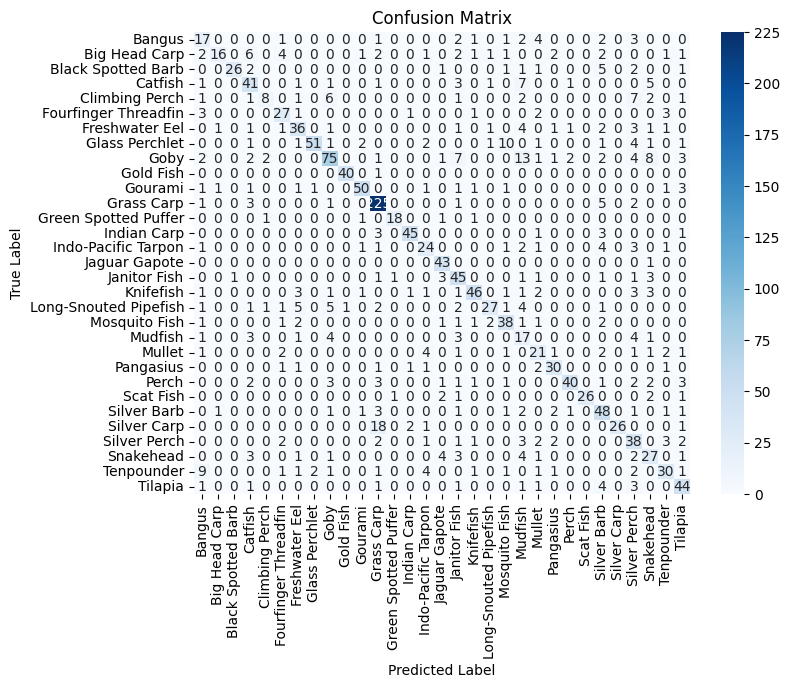

In [8]:
# 1. Evaluasi dasar pada test set
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.2f}")

# 2. Dapatkan prediksi dan label sebenarnya dari test set
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# 3. Cetak Matriks Evaluasi Lengkap
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 4. Hitung AUC-ROC Score (One-vs-Rest untuk multi-kelas)
auc_roc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
print(f"\nAUC-ROC Score (One-vs-Rest): {auc_roc:.2f}")

# 5. Visualisasikan Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

###  Matriks Evaluasi Global

Tabel berikut menyajikan hasil evaluasi kinerja model secara keseluruhan berdasarkan tiga metrik utama, yaitu *Accuracy*, *Macro Average F1-Score*, dan *Weighted Average F1-Score*:

| Matriks Evaluasi    | Nilai |
| ------------------- | ----- |
| Accuracy            | 0.71  |
| Macro Average F1    | 0.68  |
| Weighted Average F1 | 0.71  |

---

### Penjelasan Metrik Evaluasi

**1. Accuracy**

Accuracy sebesar 0.71 menunjukkan bahwa sebanyak 71% prediksi model terhadap data uji sesuai dengan label yang benar. Metrik ini mudah diinterpretasikan dan cukup representatif apabila distribusi kelas pada dataset seimbang. Namun, dalam kasus klasifikasi multikelas dengan distribusi data yang tidak merata, seperti pada dataset ini, accuracy kurang mampu menggambarkan kinerja model secara menyeluruh.

**2. Macro Average F1-Score**

Macro Average F1-Score memiliki nilai sebesar 0.68. Metrik ini menghitung rata-rata *F1-Score* dari setiap kelas tanpa mempertimbangkan jumlah sampel per kelas (support). Oleh karena itu, macro average F1-Score lebih tepat digunakan untuk mengevaluasi kinerja model secara seimbang terhadap seluruh kelas, termasuk kelas minoritas.

**3. Weighted Average F1-Score**

Weighted Average F1-Score sebesar 0.71 diperoleh dengan menghitung *F1-Score* setiap kelas yang kemudian dibobot berdasarkan jumlah sampel di masing-masing kelas. Metrik ini memberikan gambaran performa model secara keseluruhan dengan mempertimbangkan distribusi data. Dengan demikian, weighted average F1-Score lebih merepresentasikan kondisi nyata model terhadap keseluruhan data uji.

---

### Matriks Evaluasi Terbaik

Berdasarkan hasil evaluasi yang diperoleh, *F1-Score* (baik dalam bentuk *macro average* maupun *weighted average*) merupakan metrik yang paling tepat untuk mengevaluasi kinerja model pada skenario klasifikasi multikelas dengan distribusi data yang tidak merata. Hal ini disebabkan oleh kemampuan F1-Score dalam menangani ketidakseimbangan antara *precision* dan *recall* di setiap kelas.

Pemilihan antara macro dan weighted average F1-Score dapat disesuaikan dengan tujuan evaluasi:

* Jika ingin memastikan performa setara terhadap semua kelas (termasuk kelas minoritas), maka *macro average* lebih tepat.
* Jika ingin menilai performa model secara keseluruhan berdasarkan proporsi jumlah data, maka *weighted average* dapat digunakan.

Dengan mempertimbangkan kedua aspek tersebut, dapat disimpulkan bahwa *F1-Score* merupakan indikator kinerja yang paling relevan dalam evaluasi model ini.

---